In [13]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys

%matplotlib inline

# !jupyter nbconvert --to script find_shifts.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [14]:
# cp.cuda.Device(int(sys.argv[1])).use()
# ntheta = int(sys.argv[2])#750  # number of angles (rotations)
# ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
# binning = int(sys.argv[4])
# niter = int(sys.argv[5])
# iter_step = int(sys.argv[6])
# ndist = int(sys.argv[7])
# st =  int(sys.argv[8])
# same_probe =  sys.argv[9]=='True'
# flg_show = False

cp.cuda.Device(0).use()
ntheta = 1500  # number of angles (rotations)
ptheta = 1500  # holography chunk size for GPU processing
binning = 0
niter = 33
iter_step = 8
ndist = 4
st = 0
same_probe = True
flg_show = True

cropx_left = 256+64
cropx_right = 256-64
cropy_up = 0
cropy_down = 256+128+32+16+64-16-32+64

n = (2048-cropx_left-cropx_right)//2**binning

ne = (2048+256+128+96)//2**binning
pn = 32  # tomography chunk size for GPU processing
center = n/2  # rotation axis

# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning  # object voxel size
norm_magnifications = magnifications/magnifications[0]
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
magnifications2 = (z1p+z2p)/z1p
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
print(norm_magnifications*ne/n)

[1.64583333 1.5780326  1.35506552 1.0477388 ]


## Read data

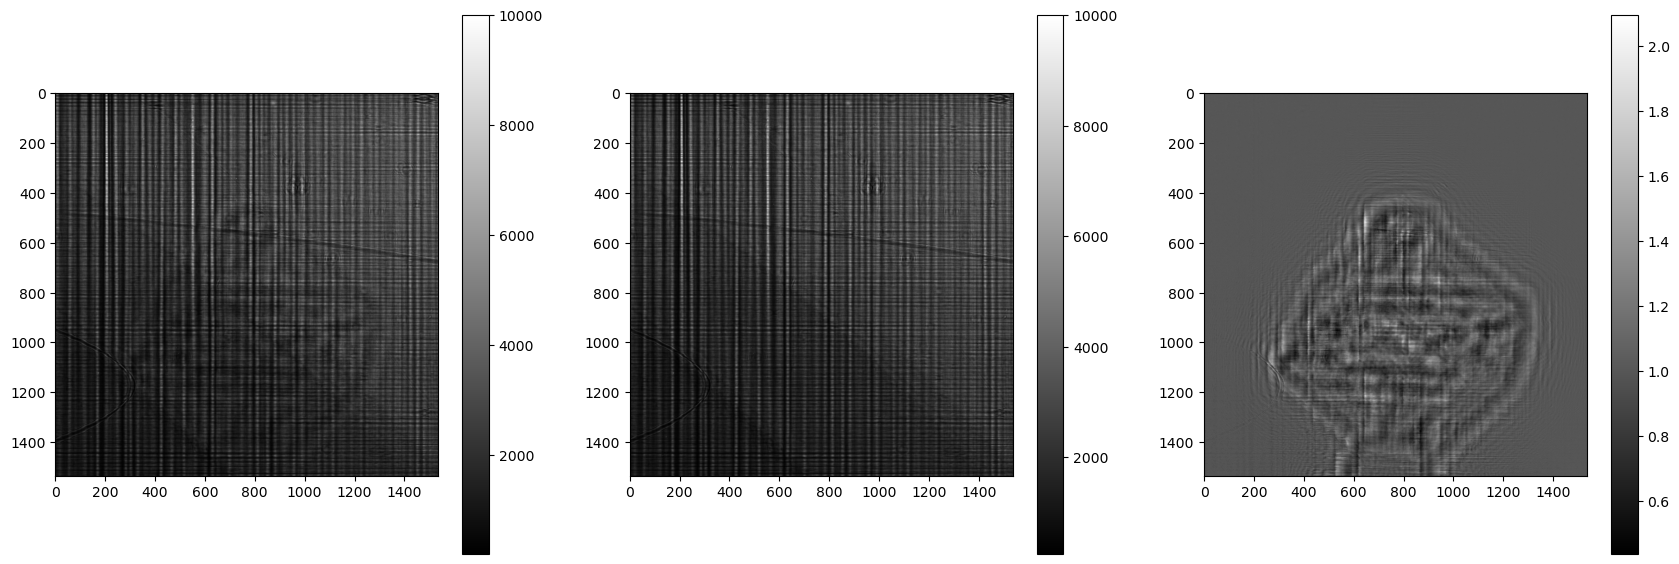

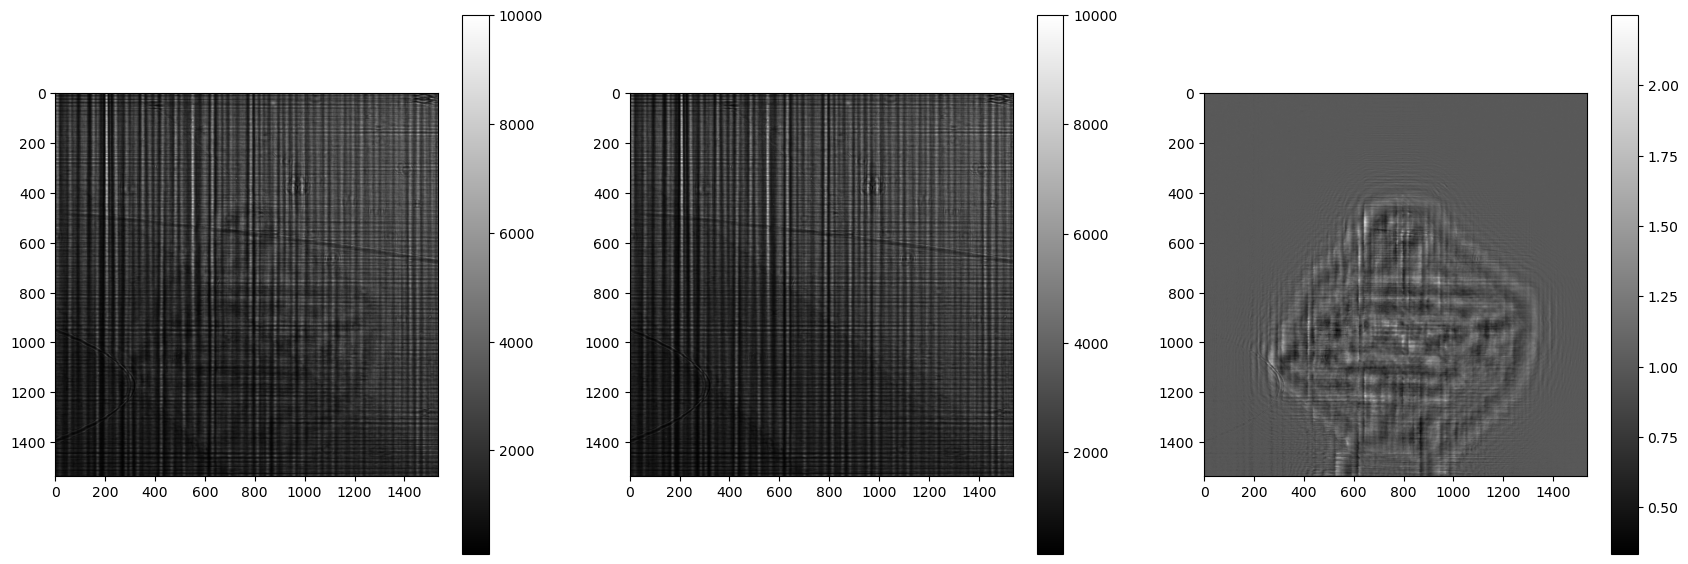

In [28]:
data00 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref00 = np.zeros([ndist,n,n],dtype='float32')
ref01 = np.zeros([ndist,n,n],dtype='float32')
dark00 = np.zeros([ndist,n,n],dtype='float32')

for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=st+j*1500//ntheta
        fname = f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/3d_ald4_ht_10nm_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data00[k,j] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref00[k] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/refHST1500.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref01[k] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/3d_ald4/3d_ald4_ht_10nm_{k+1}_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    dark00[k] = tmp

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
im=axs[0].imshow(data00[0,0],cmap='gray',vmax=10000)
fig.colorbar(im)
im=axs[1].imshow(ref00[0],cmap='gray',vmax=10000)
fig.colorbar(im)
im=axs[2].imshow(data00[0,0]/ref00[0],cmap='gray')
fig.colorbar(im)

# data00 = remove_outliers(data00)
# ref00 = remove_outliers(ref00)
# ref01 = remove_outliers(ref01)
# dark00 = remove_outliers(dark00)
# plt.imshow(dark00)
# plt.show()

data00 -= dark00[:,np.newaxis]
ref00 -= dark00
ref01 -= dark00

fig, axs = plt.subplots(1, 3, figsize=(21, 7))
im=axs[0].imshow(data00[0,0],cmap='gray',vmax=10000)
fig.colorbar(im)
im=axs[1].imshow(ref00[0],cmap='gray',vmax=10000)
fig.colorbar(im)
im=axs[2].imshow(data00[0,0]/ref00[0],cmap='gray')#,vmax=0.8,vmin=0.3)
fig.colorbar(im)
# for k in range(ndist):
#     plt.plot(np.mean(data00[k],axis=(1,2)))
#     plt.show()


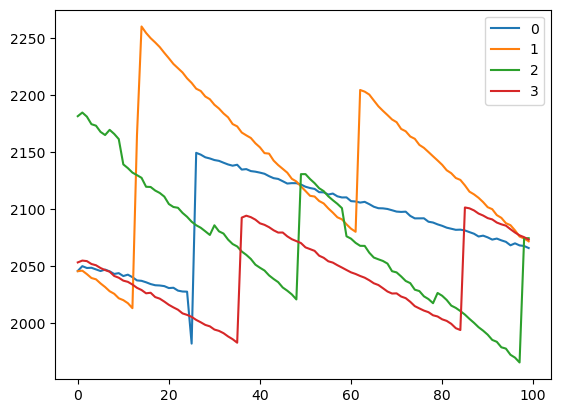

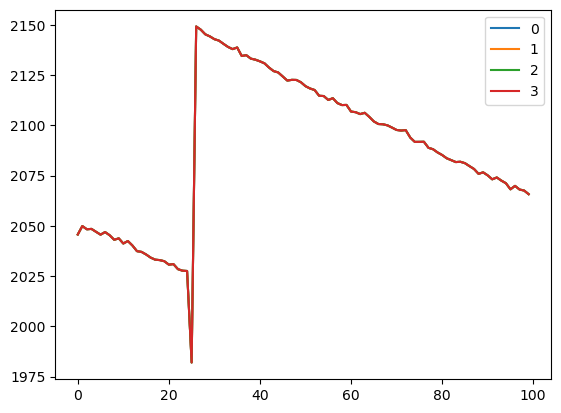

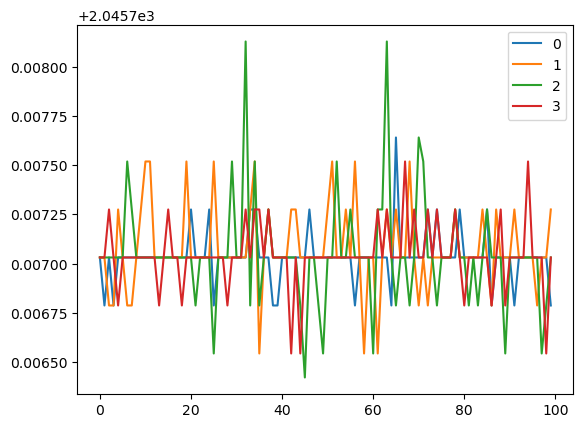

In [29]:

for k in range(ndist):
    v = np.linspace(np.mean(ref00[k]),np.mean(ref01[k]),1500)[st:1500:1500//ntheta]/np.mean(ref00[k])
    data00[k]/=v[:,np.newaxis,np.newaxis]
    data00[k]*=np.mean(ref00[0])/np.mean(ref00[k])
for k in range(ndist):
    ref00[k]*=np.mean(ref00[0])/np.mean(ref00[k])


if flg_show:
    for k in range(ndist):
        plt.plot(np.mean(data00[k],axis=(1,2)),label=f'{k}')
    plt.legend()
    plt.show()
    
for k in range(ndist):
    data00[k]*=(np.mean(data00[0],axis=(1,2))/np.mean(data00[k],axis=(1,2)))[:,np.newaxis,np.newaxis]

if flg_show:
    for k in range(ndist):
        plt.plot(np.mean(data00[k],axis=(1,2)),label=f'{k}')
    plt.legend()
    plt.show()

for k in range(ndist):
    data00*=(np.mean(data00[0,0])/np.mean(data00,axis=(2,3)))[:,:,np.newaxis,np.newaxis]


if flg_show:
    for k in range(ndist):
        plt.plot(np.mean(data00[k],axis=(1,2)),label=f'{k}')
    plt.legend()
    plt.show()


In [31]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * cp.pi
    tdata = data.copy()
    kernel = (cp.tile(cp.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*cp.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = cp.exp(-im2pi * kernel)
    tdata = cp.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (cp.tile(cp.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*cp.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = cp.exp(-im2pi * kernel)
    rec = cp.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    src_image=cp.array(src_image)
    target_image=cp.array(target_image)
    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = cp.fft.fft2(src_image)
        target_freq = cp.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = cp.fft.ifft2(image_product)
    A = cp.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = cp.column_stack(cp.unravel_index(maxima, A[0, :, :].shape))

    midpoints = cp.array([cp.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = cp.array(maxima, dtype=cp.float64)
    ids = cp.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = cp.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = cp.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = cp.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = cp.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = cp.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = cp.column_stack(
            cp.unravel_index(maxima, A[0, :, :].shape))

        maxima = cp.array(maxima, dtype=cp.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_probe_nil = cp.zeros([ndist,2],dtype='float32')
for k in range(ndist):
    #ref00[k] = shift*ref00[0]
    shifts_probe_nil[k] = registration_shift(ref00[k:k+1,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],ref00[0:1,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],upsample_factor=1000)
print(shifts_probe_nil)
# dxchange.write_tiff_stack(ref00,f'/data/viktor/tmp/ref.tiff',overwrite=True)
# for k in range(ndist):
#     ref00[k:k+1] = apply_shift(ref00[k:k+1],-shifts_probe_nil[k:k+1])
# dxchange.write_tiff_stack(ref00,f'/data/viktor/tmp/ref_aligned.tiff',overwrite=True)
# print(shifts_probe_nil)
np.save('shifts_probe_nil',shifts_probe_nil)

[[ 0.     0.   ]
 [ 0.066 -0.154]
 [ 0.146 -0.297]
 [ 0.273 -0.201]]


In [32]:
shifts_probe = cp.zeros([ndist,ntheta,2],dtype='float32')
for k in range(ntheta):
    shifts_probe[:,k]=registration_shift(data00[:,k,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],ref00[:,n//2-n//4:n//2+n//4,n//2-n//4:n//2+n//4],upsample_factor=10000)
    print(k,shifts_probe[:,k])
print(shifts_probe.shape,shifts_probe_nil.shape)
np.save('shifts_probe',shifts_probe)


0 [[-0.16   -0.0293]
 [-0.1149 -0.002 ]
 [-0.0637  0.0122]
 [-0.0372  0.0364]]
1 [[-0.1435 -0.0376]
 [-0.1476 -0.0157]
 [-0.088   0.0073]
 [-0.0496  0.0252]]
2 [[-0.1387 -0.0822]
 [-0.1292  0.0171]
 [-0.0883  0.0149]
 [-0.0631  0.0206]]
3 [[-0.1847 -0.0759]
 [-0.1063  0.0231]
 [-0.0795 -0.0019]
 [-0.0505  0.0352]]
4 [[-0.1623 -0.0585]
 [-0.1246  0.0188]
 [-0.0851 -0.0095]
 [-0.0478  0.0019]]
5 [[-0.1362 -0.0828]
 [-0.109   0.013 ]
 [-0.1156 -0.0413]
 [-0.0838 -0.0082]]
6 [[-1.525e-01 -7.750e-02]
 [-1.196e-01 -1.000e-04]
 [-1.091e-01  3.400e-03]
 [-7.000e-02  8.800e-03]]
7 [[-0.1548 -0.0746]
 [-0.1496 -0.013 ]
 [-0.0933 -0.0081]
 [-0.0491  0.0304]]
8 [[-0.174  -0.0836]
 [-0.1134  0.0506]
 [-0.0651  0.0374]
 [-0.0363  0.0222]]
9 [[-0.1857 -0.0388]
 [-0.1218  0.0392]
 [-0.071   0.0411]
 [-0.0586  0.0162]]
10 [[-0.1596 -0.0567]
 [-0.0871  0.0385]
 [-0.0938  0.029 ]
 [-0.0519  0.0258]]
11 [[-0.1681 -0.0703]
 [-0.1152  0.0503]
 [-0.0859  0.0302]
 [-0.0509 -0.005 ]]
12 [[-0.1466 -0.0842]
 [-0

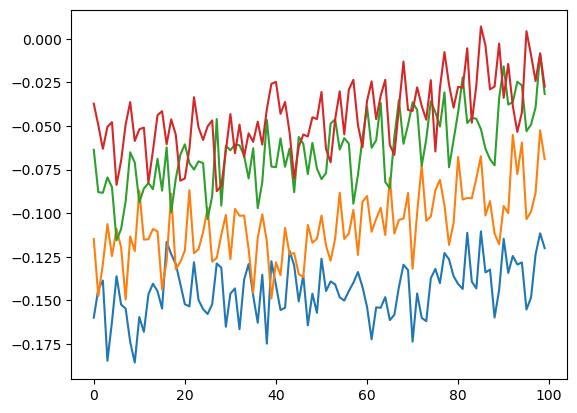

In [34]:
shifts_probe = shifts_probe#+shifts_probe_nil[:,np.newaxis]
for k in range(ndist):
    plt.plot(shifts_probe[k,:,0].get())
plt.show()

# Dark-flat field correction

In [ ]:

data0 = data00.copy()
ref0 = ref00.copy()
ref0[ref0<0] = 0
data0[data0<0]=0
shifts_probe_nil = np.load('shifts_probe_nil.npy')[:]/2**binning
shifts_probe = np.load('shifts_probe.npy')[:,st:1500:1500//ntheta]/2**binning

ref0_shifted_nil_check = apply_shift(ref0,-shifts_probe_nil)
ref0_shifted = np.tile(ref0[0:1,np.newaxis],[ndist,ntheta,1,1])
for k in range(ntheta):
    ref0_shifted[:,k] = apply_shift(ref0_shifted[:,k],shifts_probe[:,k]+shifts_probe_nil)

rdata=data0/(ref0_shifted+1e-9)
# rdata=data0/(ref0[:,np.newaxis]+1e-9)
for k in range(ndist):
    dxchange.write_tiff(rdata[k],f'/data/viktor/tmp/tn{k}.tiff',overwrite=True)


: 

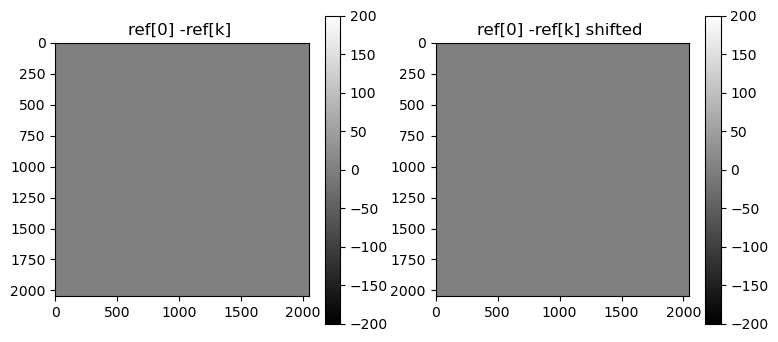

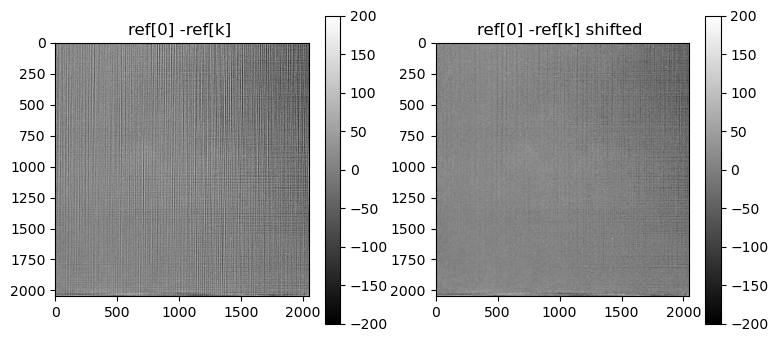

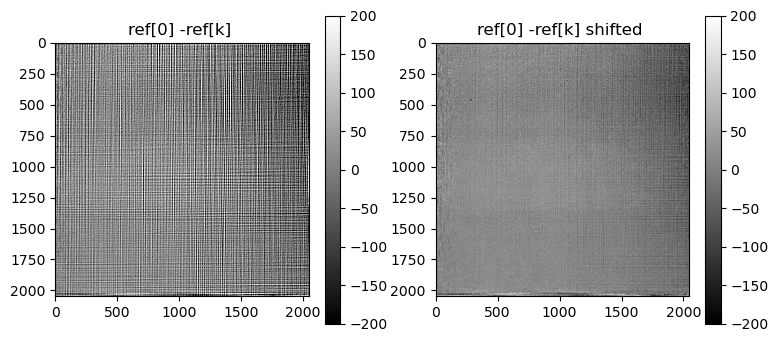

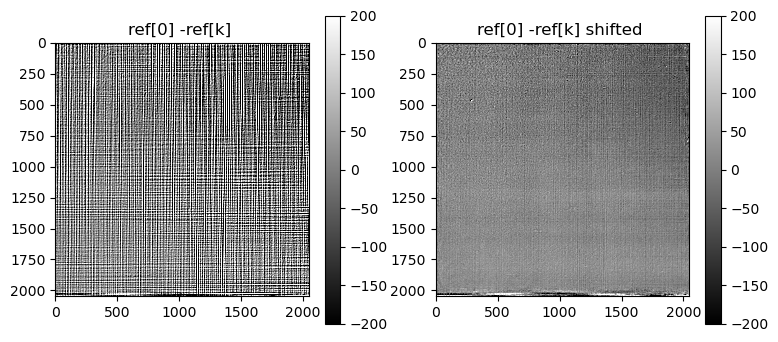

In [ ]:
if flg_show:

    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(ref0[0]-ref0[k],cmap='gray',vmin=-200,vmax=200)
        axs[0].set_title('ref[0] -ref[k] ')
        fig.colorbar(im)
        im=axs[1].imshow(ref0_shifted_nil_check[0]-ref0_shifted_nil_check[k],cmap='gray',vmin=-200,vmax=200)
        axs[1].set_title('ref[0] -ref[k] shifted ')
        fig.colorbar(im)

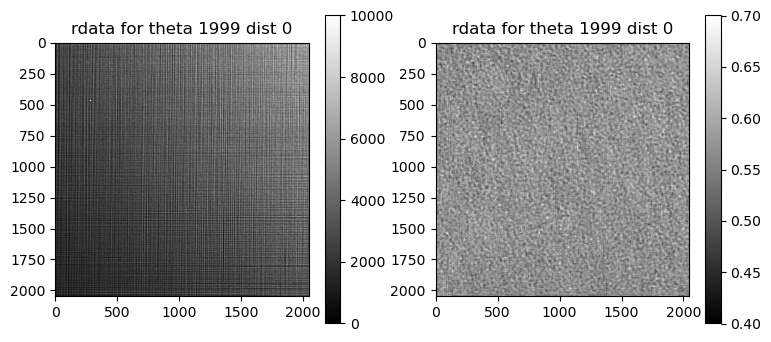

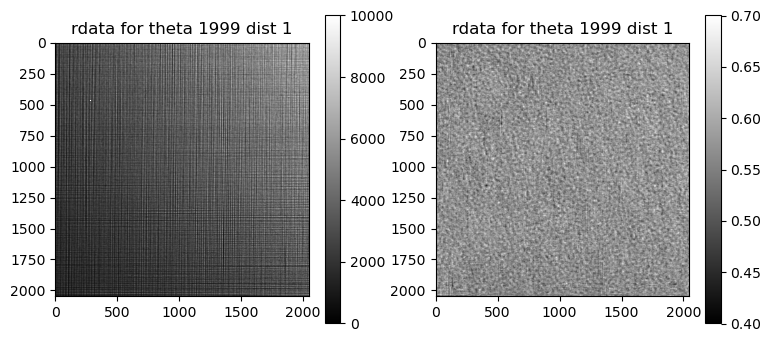

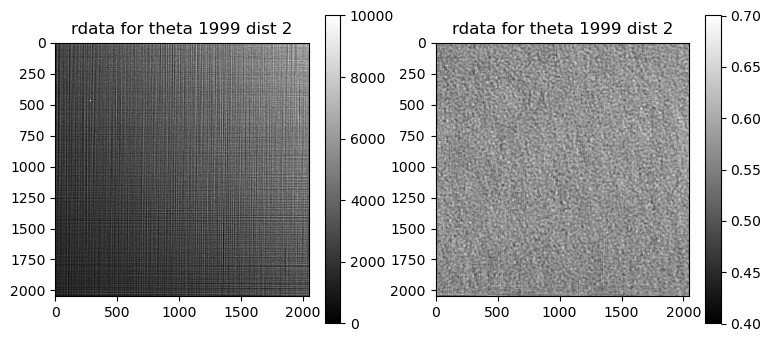

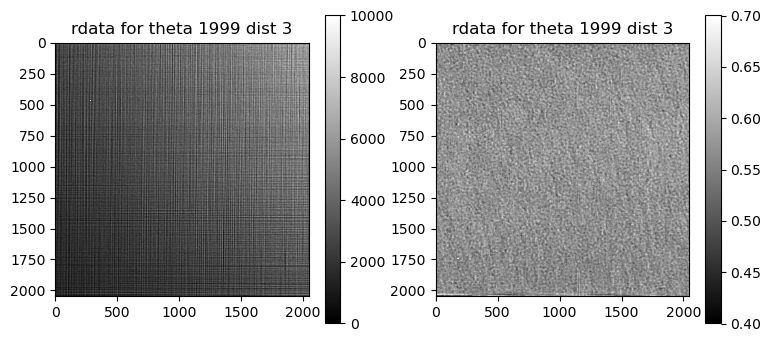

In [ ]:
if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(data00[k,-1],cmap='gray',vmin = 0,vmax=10000 )
        axs[0].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata[k,-1],cmap='gray',vmin = 0.4,vmax=.7)
        axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)

In [13]:
rdata_scaled = rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = ndimage.zoom(rdata[k,j],1/norm_magnifications[k])
        rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled[0,0],cmap='gray',vmin = 0.4,vmax=0.7 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled[k,0],cmap='gray',vmin = 0.4,vmax=0.7 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled[0,0]-rdata_scaled[k,0],cmap='gray',vmin =-0.1,vmax=.1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)        

KeyboardInterrupt: 

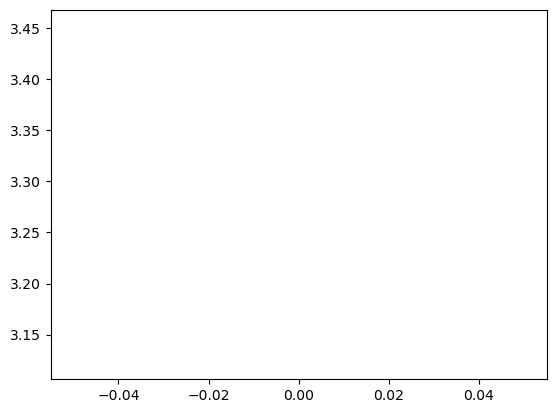

In [ ]:
shifts_random = np.zeros([ndist,ntheta,2],dtype='float32')
for k in range(ndist):
    s = np.loadtxt(f'/data/viktor/id16a/brain/X2O2_WM_contShift_030nm_a_2_/correct.txt').astype('float32')[st:2000:2000//ntheta]/norm_magnifications[k]    
    shifts_random[k,:,0] = s[:,1]+(1024-(2048+cropy_up-cropy_down)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]
    shifts_random[k,:,1] = s[:,0]+(1024-(2048+cropx_left-cropx_right)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]
plt.plot(shifts_random[0,:,1])
plt.show()

# Total shifts in pixels before normalized scaling

In [ ]:

import scipy.io 
shifts_new = -scipy.io.loadmat('/data/viktor/id16a/brain/rhapp_py.mat')['rhapp'][:,:,st:2000:2000//ntheta].swapaxes(0,2).swapaxes(0,1)[:ndist]
shifts_new+=shifts_random
shifts_new/=2**binning
shifts = shifts_new
print(shifts)


[[[  1.781937     3.28713107]]

 [[ -5.87371314 -24.69997223]]

 [[ 14.82283403  29.4832655 ]]

 [[ 17.38345549 -31.38022276]]]


# TEST: Scale initial data to 1 magnification and apply all shifts

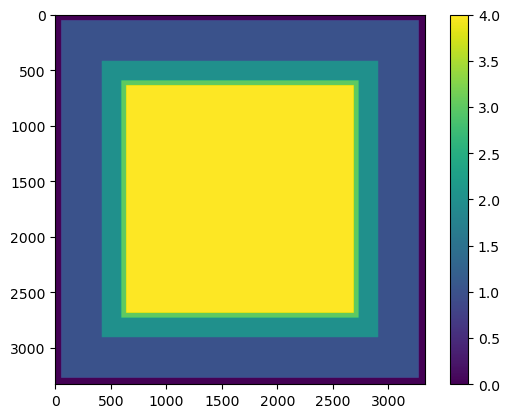

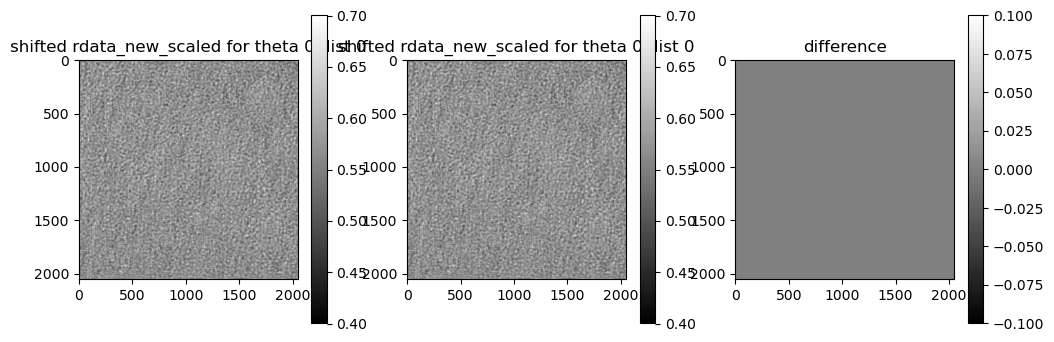

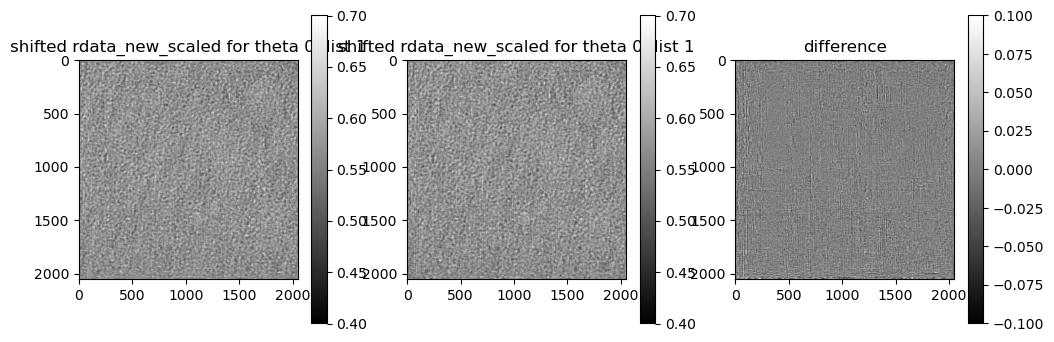

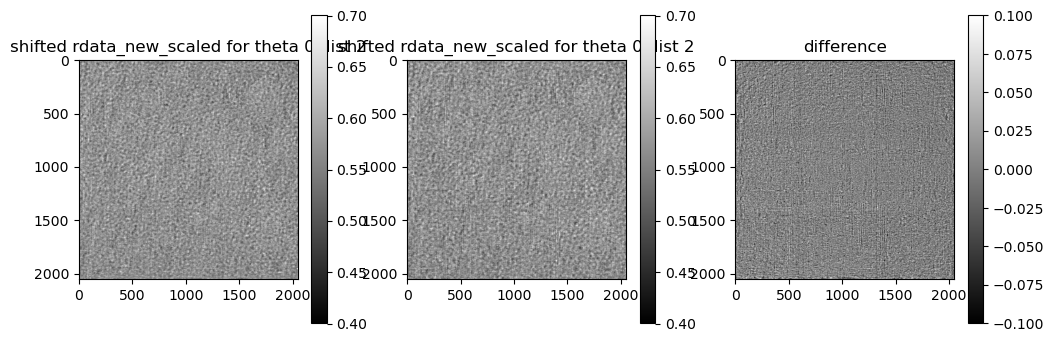

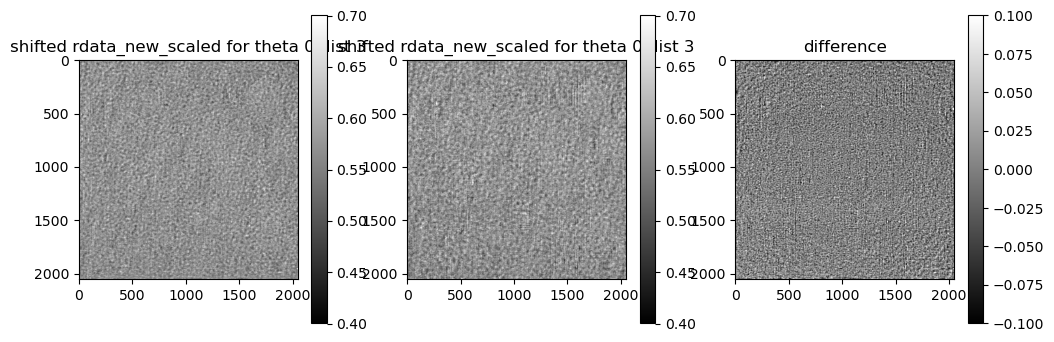

In [ ]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    n = psi.shape[-1]
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_scaled_new = np.ones([ndist,ntheta,ne,ne],dtype='float32')#rdata.copy()
mask = np.zeros([ne,ne],dtype='float32')#rdata.copy()
for j in range(ntheta):
    for k in range(ndist):    
        a = apply_shift(rdata[k,j:j+1],-shifts[k,j:j+1]*norm_magnifications[k,np.newaxis,np.newaxis])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        if a.shape[-1]%2==1:
            a=a[:-1,:-1]
        if j==0:
            mask[-a.shape[0]//2+ne//2:a.shape[0]//2+ne//2,-a.shape[0]//2+ne//2:a.shape[0]//2+ne//2]+=1
        a = np.pad(a,((-a.shape[0]//2+ne//2,-a.shape[0]//2+ne//2),(-a.shape[0]//2+ne//2,-a.shape[0]//2+ne//2)),'symmetric')        
        rdata_scaled_new[k,j] = a
        
        

if flg_show:
    plt.imshow(mask)
    plt.colorbar()
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled_new[0,-1,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2],cmap='gray',vmin = 0.4,vmax=0.7)
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled_new[k,-1,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2],cmap='gray',vmin = 0.4,vmax=0.7)
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled_new[0,-1,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]-rdata_scaled_new[k,-1,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2],cmap='gray',vmin = -0.1,vmax=0.1)
        axs[2].set_title(f'difference')
        fig.colorbar(im)          
        
    

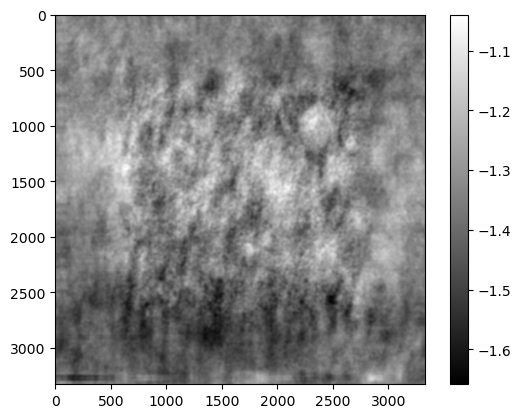

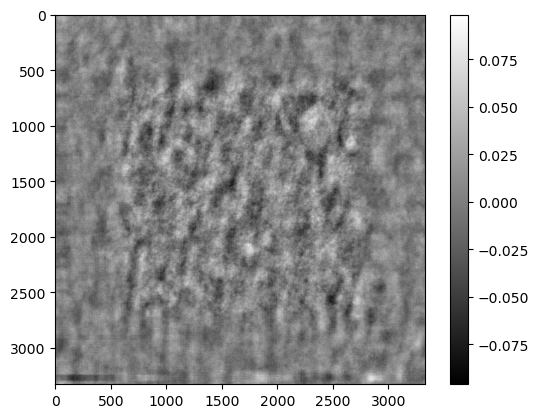

/data/vnikitin/holo/brain/rfinal_probe_True_2048_1_4_0/MultiPaganin.tiff


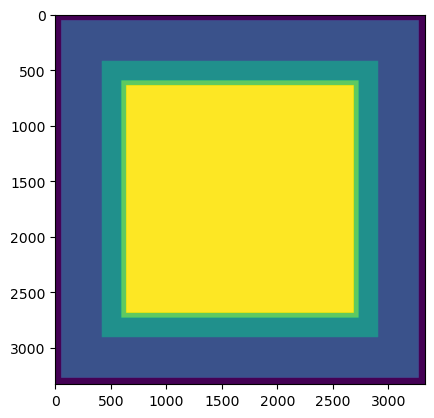

NameError: name 'done' is not defined

In [ ]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       radsj = cp.array(rads[j])
       rad_freq = cp.fft.fft2(radsj)
       taylorExp = cp.sin(cp.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = cp.real(  cp.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase.get()

def multiPaganin(rads, wlen, dists, delta_beta, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function. This 
    method relies on linearization of the direct problem, based  on  the
    first  order  Taylor expansion of the transmittance function.
    Found in Yu et al. 2018 and adapted from Cloetens et al. 1999


    Parameters
    ----------
    rad : 2D-array
        projection.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dist : float
        Object to detector distance (propagation distance) in mm.
    delta : float    
        refractive index decrement
    beta : float    
        absorption index
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space
    """    
    numerator = 0
    denominator = 0    
    for j in range(0, len(dists)):    
        radsj = cp.array(rads[j])
        rad_freq = cp.fft.fft2(radsj)    
        taylorExp = 1 + wlen * dists[j] * np.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = cp.log(cp.real(  cp.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return phase.get()

distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = cp.fft.fftfreq(ne,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recMultiPaganin = np.zeros([ntheta,ne,ne],dtype='complex64')
recCTF = np.zeros([ntheta,ne,ne],dtype='complex64')
for k in range(ntheta):
    #rads = np.pad(rdata_scaled_new[:ndist,k],((0,0),(n//2,n//2),(n//2,n//2)),'edge')
    rads = rdata_scaled_new[:ndist,k]
    recMultiPaganin[k] = np.exp(1j*multiPaganin(rads, wlen, distances_rec,27, fx, fy, 1e-12))
    a = CTFPurePhase(rads, wlen, distances_rec,fx, fy, 1e-3)
    #a[mask>2]/=(mask[mask>2]-2)
    recCTF[k] = np.exp(1j*a)#[n//2:-n//2,n//2:-n//2]
if flg_show:
    plt.imshow(np.angle(recMultiPaganin[0]),cmap='gray')
    plt.colorbar()
    plt.show()
if flg_show:
    plt.imshow(np.angle(recCTF[0]),cmap='gray')
    plt.colorbar()
    plt.show()
print(f'/data/vnikitin/holo/brain/rfinal_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/MultiPaganin.tiff')
dxchange.write_tiff(np.angle(recMultiPaganin),f'/data/vnikitin/holo/brain/rfinal_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/MultiPaganin.tiff',overwrite=True)
dxchange.write_tiff(np.angle(recCTF),         f'/data/vnikitin/holo/brain/rfinal_probe_{same_probe}_{n}_{ntheta}_{ndist}_{st}/recCTF.tiff',overwrite=True)


plt.imshow(mask)
plt.show()
done
